In [21]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')

In [7]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)

In [5]:
#bank_df = bank_df[bank_df.year == 2014] #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = 0 #initialize colum for cumulative amount
#add cumulative percent by count and amount
cumul_amount = 0
for index, row in bank_df.iterrows():
    cumul_amount += row['pct_amt']
    bank_df.loc[index, 'cumul_amt_pct'] = cumul_amount




In [10]:
bank_df.head() #check dataframe for columns

,year,income,amount,mult,pct_amt,cumul_amt_pct
76234,2013,4,1,0.250000,7.708127e-09,7.708127e-09
77074,2013,19,1,0.052632,7.708127e-09,1.541625e-08
232210,2011,33,1,0.030303,7.708127e-09,2.312438e-08
229962,2011,16,2,0.125000,1.541625e-08,3.854064e-08
80784,2013,41,3,0.073171,2.312438e-08,6.166502e-08


400.963857957 std
442.363262216 mean
338.0 median
2500.0 max mult
0.00314465408805 min mult
1600.0 98%
559.0 q3
199.0 q1
48.0 02%
360.0 iqr
-341.0 min_q 1099.0 max_q


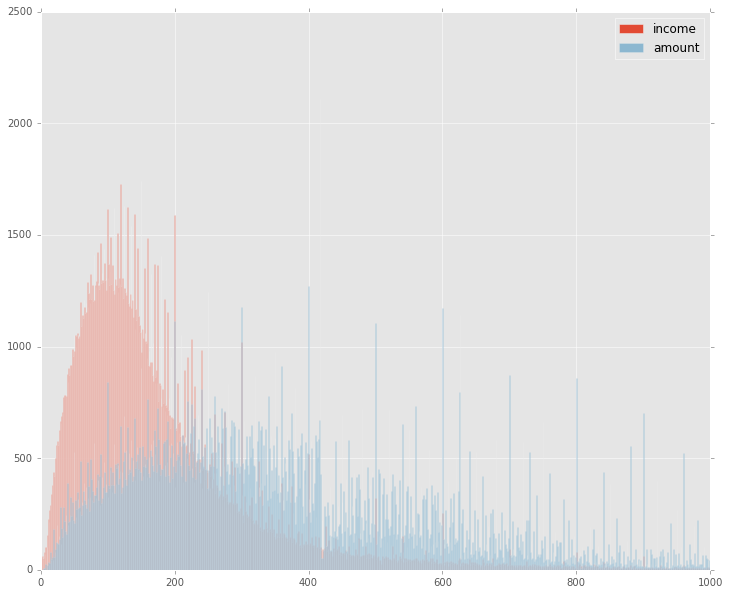

In [11]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,1000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.show()

std 91.2671236696
mean 109.266766579
median 92.0
max_mult 75.0
min_mult 0.172413793103
q98 347.78
q02 20.0
q75 132.0
q25 58.0
iqr 74.0
min_q -53.0
max_q 243.0


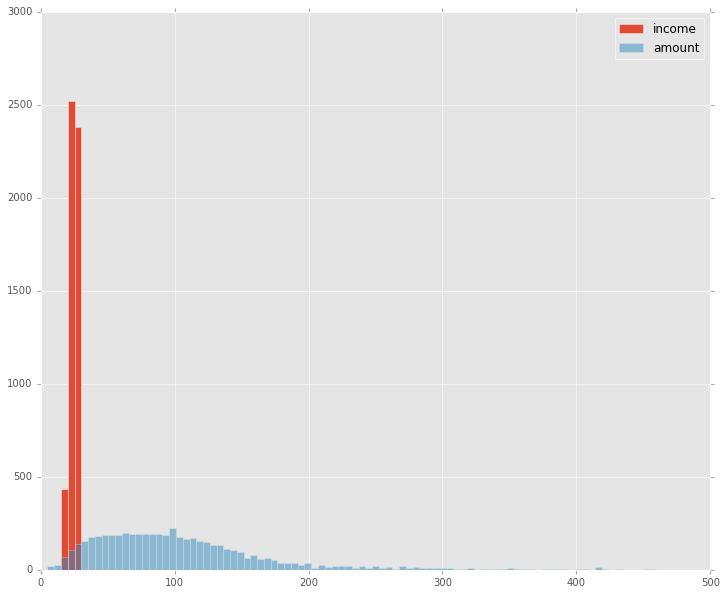

In [23]:
bin_2030 = bank_df[(bank_df.income >=20) & (bank_df.income < 30)] #create bin of 20 to 30k income
#generate descriptive statistics and store for later comparison
bin_2030_stats = OrderedDict({})
bin_2030_stats['std']= bin_2030.amount.std()
bin_2030_stats['mean'] = bin_2030.amount.mean()
bin_2030_stats['median'] = bin_2030.amount.median()
bin_2030_stats['max_mult'] = bin_2030.mult.max()
bin_2030_stats['min_mult'] = bin_2030.mult.min()
bin_2030_stats['q98'] = bin_2030.amount.quantile(q=.98)
bin_2030_stats['q02'] = bin_2030.amount.quantile(q=.02)
bin_2030_stats['q75'] = bin_2030.amount.quantile(q=.75)
bin_2030_stats['q25'] = bin_2030.amount.quantile(q=.25)
bin_2030_stats['iqr'] = bin_2030_stats['q75'] - bin_2030_stats['q25']
bin_2030_stats['min_q'] = bin_2030_stats['q25'] - 1.5 * bin_2030_stats['iqr']
bin_2030_stats['max_q'] = bin_2030_stats['q75'] + 1.5 * bin_2030_stats['iqr']

for key, value in bin_2030_stats.items():
    print(key, value)

amt = bin_2030.amount
inc = bin_2030.income
bins = np.linspace(0,500, 100)
bin_viz = plt.figure(figsize=(12,10))
plt.hist(inc, bins, label='income', alpha=1)
plt.hist(amt, bins, label='amount', alpha=.5)

plt.legend(loc='upper right')
plt.show(bin_viz)

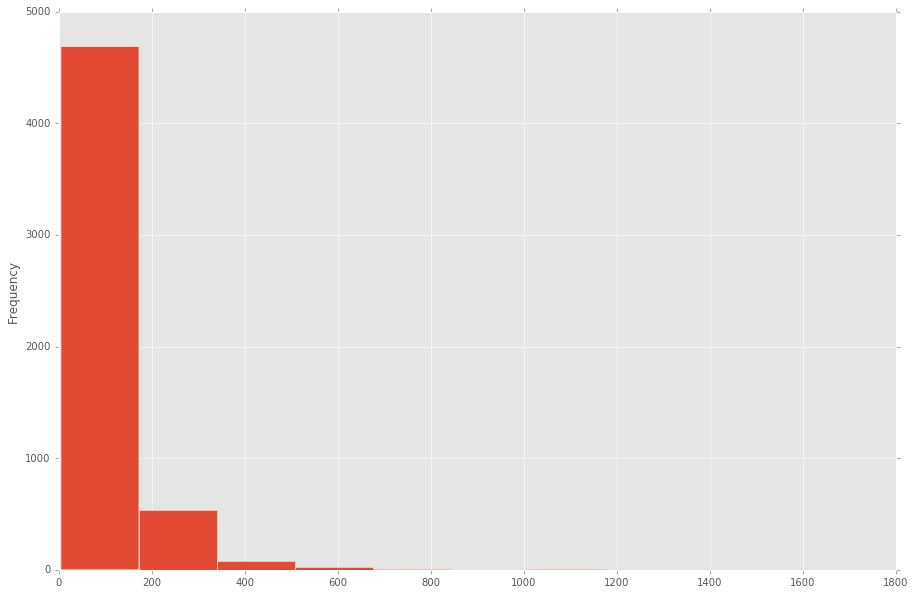

In [25]:
amt_dist = plt.figure(figsize=(15,10))
x = bin_2030.income
#plt.xticks(np.arange(min(x), max(x)+1, 150))

#plt.plot(kind='hist')
bin_2030.amount.plot.hist()

91.2671236696 std
109.266766579 mean
92.0 median
75.0 max mult
0.172413793103 min mult
347.78 98%
132.0 q3
58.0 q1
20.0 02%
74.0 iqr


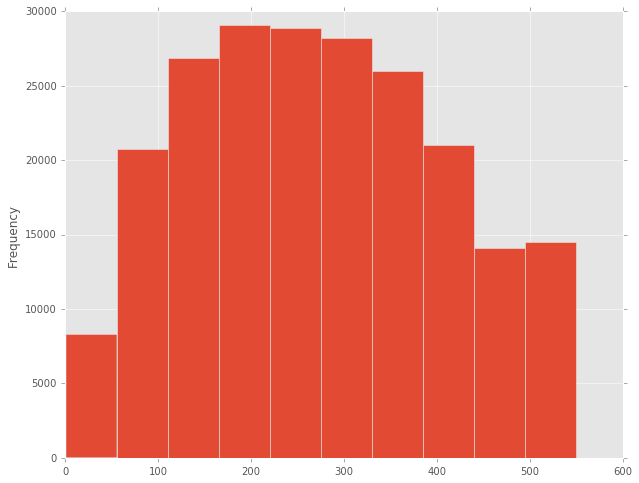

In [33]:

bank_viz = plt.figure(figsize=(10,8))
bank_df.amount[bank_df.amount < 550].plot.hist()

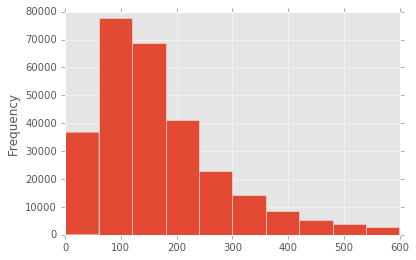

In [35]:
bank_df.income[bank_df.income < 600].plot.hist()

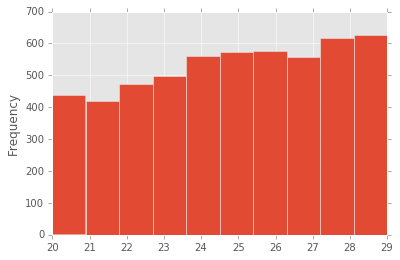

In [36]:
bin_2030.income.plot.hist()

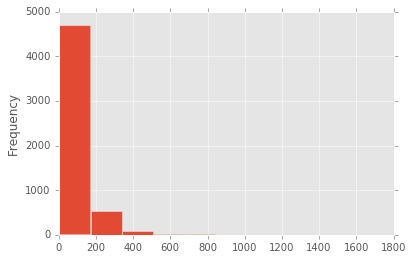

In [37]:
bin_2030.amount.plot.hist()

In [40]:
print(bin_2030.amount.std(), 'std')
print(bin_2030.amount.mean(), 'mean')
print(bin_2030.amount.median(), 'median')
print(bin_2030.mult.max(), 'max mult')
print(bin_2030.mult.min(), 'min mult')
print(bin_2030.amount.quantile(q=.98), '98%')
print(bin_2030.amount.quantile(q=.75), 'q3')
print(bin_2030.amount.quantile(q=.25), 'q1')
print(bin_2030.amount.quantile(q=.02), '02%')
q1 = bin_2030.amount.quantile(q=.25)
q3 = bin_2030.amount.quantile(q=.75)
q98 = bin_2030.amount.quantile(q=.98)
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr
max_q = q3 + 1.5*iqr
print(min_q, max_q)

91.2671236696 std
109.266766579 mean
92.0 median
75.0 max mult
0.172413793103 min mult
347.78 98%
132.0 q3
58.0 q1
20.0 02%
74.0 iqr
-53.0 243.0


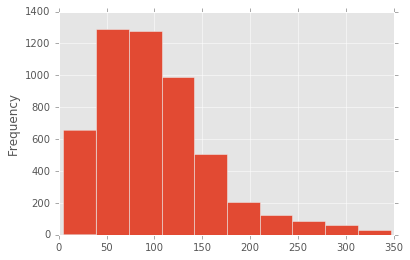

In [41]:
bin_2030.amount[bin_2030.amount < q98].plot.hist()

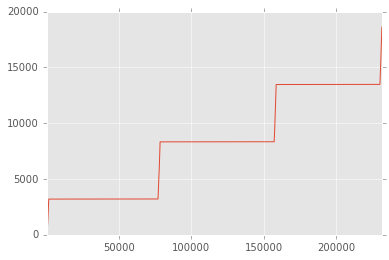

In [45]:
bin_2030.count_amount.cumsum().plot()

In [44]:
bin_2030.head()

,year,income,amount,count_amount,mult
607,2014,20,10,1,0.50
608,2014,20,12,1,0.60
609,2014,20,20,1,1.00
610,2014,20,21,1,1.05
611,2014,20,23,2,1.15


In [ ]:
#exclude data with quality edit fails